In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib # pltに日本語を組み込むのに必要
import statsmodels.api as sm

In [2]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    # 移動平均と移動標準偏差を求める
    # windows にデータが取りそうな周期を入れる
    rolmean = timeseries.rolling(window = 7).mean()
    rolstd = timeseries.rolling(window = 7).std()
    # 元のデータや移動平均たちをプロットする
    orig = plt.plot(timeseries, color='blue',label='元のデータ')
    mean = plt.plot(rolmean, color='red', label='移動平均')
    std = plt.plot(rolstd, color='black', label = '移動標準偏差')
    plt.legend(loc='best')
    plt.title('移動平均＆移動標準偏差')
    plt.show(block=False)
    # 拡張ディッキー=フラー検定を行い、主要データを書き出す
    print ('拡張ディッキー–フラー検定:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['検定統計量','p-値','使用したラグ','使用データ数'])
    for key,value in dftest[4].items():
        dfoutput['棄却値 (%s)'%key] = value
    print (dfoutput)

In [3]:
dt = pd.read_csv('data.csv', index_col='Date', parse_dates=True, dtype='float')
dt = dt.dropna(axis=0)
dt

,y
Date,
2020-05-08,88.0
2020-05-09,114.0
2020-05-10,69.0
2020-05-11,45.0
2020-05-12,80.0
...,...
2020-11-03,866.0
2020-11-04,624.0
2020-11-05,1048.0


------------

- 自己相関係数や偏自己相関係数を見る
- 青い背景はそれぞれの95%信頼区間

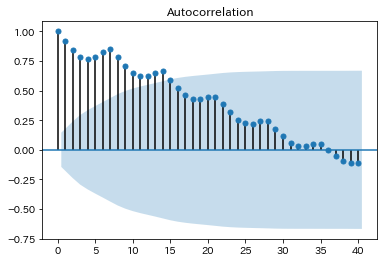

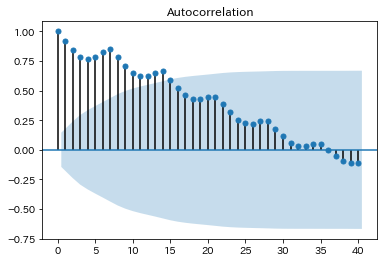

In [4]:
sm.graphics.tsa.plot_acf(dt, lags=40)

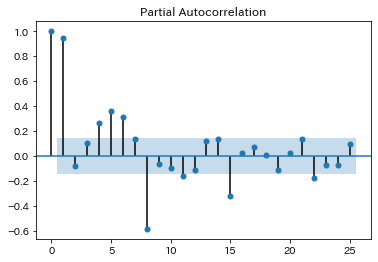

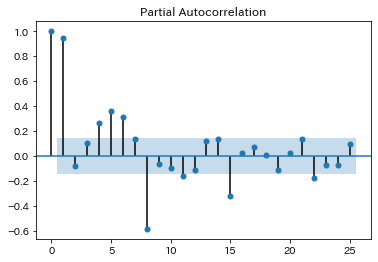

In [5]:
sm.graphics.tsa.plot_pacf(dt, lags=25, method='ols')

- 定義した関数を使い、定常性の検定を行う

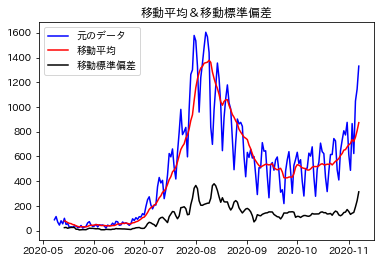

拡張ディッキー–フラー検定:
検定統計量         -1.846602
p-値            0.357583
使用したラグ        14.000000
使用データ数       169.000000
棄却値 (1%)      -3.469648
棄却値 (5%)      -2.878799
棄却値 (10%)     -2.575971
dtype: float64


In [6]:
test_stationarity(dt)

- seasonal_decompose を使えば季節周期を含め分解できる
- 原理（中の計算方法）は不明なので、あくまで参考に

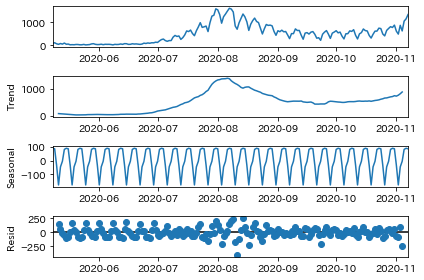

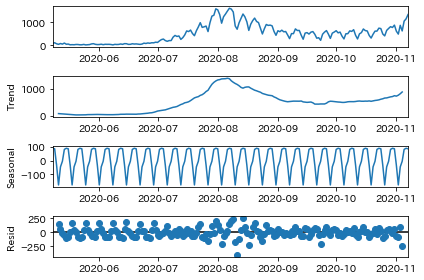

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(dt, period=7)
decomposition.plot()

- for構文でフィッティングするための、各パラメータの上限を決める
- patternで何回計算をループさせるかを参考に出力させる

In [8]:
max_p = 3
max_q = 3
max_d = 1
max_sp = 1
max_sq = 1
max_sd = 1

pattern = max_p*(max_q + 1)*(max_d + 1)*(max_sp + 1)*(max_sq + 1)*(max_sd + 1)

modelSelection = pd.DataFrame(index=range(pattern), columns=["model", "aic"])
pattern

192

In [9]:
import warnings
 
warnings.filterwarnings("ignore")

num = 0

for p in range(1, max_p + 1):
    for d in range(0, max_d + 1):
        for q in range(0, max_q + 1):
            for sp in range(0, max_sp + 1):
                for sd in range(0, max_sd + 1):
                    for sq in range(0, max_sq + 1):
                        sarima = sm.tsa.SARIMAX(dt, order=(p,d,q), seasonal_order=(sp,sd,sq,7), enforce_stationarity = True, enforce_invertibility = True).fit(method='bfgs', maxiter=300, disp=False)
                        print("order=(" + str(p) + ","+ str(d) + ","+ str(q) + "), season=("+ str(sp) + ","+ str(sd) + "," + str(sq) + "), AIC=" + str(sarima.aic))
                        modelSelection.iloc[num]["model"] = "order=(" + str(p) + ","+ str(d) + ","+ str(q) + "), season=("+ str(sp) + ","+ str(sd) + "," + str(sq) + ")"
                        modelSelection.iloc[num]["aic"] = sarima.aic
                        num = num + 1

order=(1,0,0), season=(0,0,0), AIC=2357.7358400773264
order=(1,0,0), season=(0,0,1), AIC=2306.229323131497
order=(1,0,0), season=(0,1,0), AIC=2177.135653045786
order=(1,0,0), season=(0,1,1), AIC=2147.4338276866383
order=(1,0,0), season=(1,0,0), AIC=2253.773655708116
order=(1,0,0), season=(1,0,1), AIC=2234.4632473682404
order=(1,0,0), season=(1,1,0), AIC=2155.197397271788
order=(1,0,0), season=(1,1,1), AIC=2148.893058739323
order=(1,0,1), season=(0,0,0), AIC=2358.893705290352
order=(1,0,1), season=(0,0,1), AIC=2308.1220747455673
order=(1,0,1), season=(0,1,0), AIC=2178.4101750696072
order=(1,0,1), season=(0,1,1), AIC=2148.9547755706544
order=(1,0,1), season=(1,0,0), AIC=2253.975269730886
order=(1,0,1), season=(1,0,1), AIC=2235.9812410100462
order=(1,0,1), season=(1,1,0), AIC=2156.7204930838134
order=(1,0,1), season=(1,1,1), AIC=2150.2173798053454
order=(1,0,2), season=(0,0,0), AIC=2352.9556562935095
order=(1,0,2), season=(0,0,1), AIC=2300.656335526138
order=(1,0,2), season=(0,1,0), AIC=2

order=(3,0,3), season=(0,1,0), AIC=2195.8414463495014
order=(3,0,3), season=(0,1,1), AIC=2159.2023695420467
order=(3,0,3), season=(1,0,0), AIC=2317.3960057697395
order=(3,0,3), season=(1,0,1), AIC=2294.6012327072076
order=(3,0,3), season=(1,1,0), AIC=2169.459787403665
order=(3,0,3), season=(1,1,1), AIC=2164.934840266116
order=(3,1,0), season=(0,0,0), AIC=2329.6751644050055
order=(3,1,0), season=(0,0,1), AIC=2284.1287782243458
order=(3,1,0), season=(0,1,0), AIC=2172.6072405216964
order=(3,1,0), season=(0,1,1), AIC=2137.184637113345
order=(3,1,0), season=(1,0,0), AIC=2238.1325835341245
order=(3,1,0), season=(1,0,1), AIC=2220.8283774969937
order=(3,1,0), season=(1,1,0), AIC=2147.615736509982
order=(3,1,0), season=(1,1,1), AIC=2138.435065757966
order=(3,1,1), season=(0,0,0), AIC=2314.0030769296163
order=(3,1,1), season=(0,0,1), AIC=2283.073609442002
order=(3,1,1), season=(0,1,0), AIC=2172.3280298281147
order=(3,1,1), season=(0,1,1), AIC=2135.499268387166
order=(3,1,1), season=(1,0,0), AIC=

- AICが最小のものが一番いいのでそれを抜き出して、モデルをフィッティングする

In [10]:
modelSelection[modelSelection.aic == min(modelSelection.aic)]

,model,aic
171,"order=(3,1,1), season=(0,1,1)",2135.5


In [11]:
bestSARIMA = sm.tsa.SARIMAX(dt, order=(3,1,1), seasonal_order=(0,1,1,7), enforce_stationarity = True, enforce_invertibility = True).fit()

- 残差の自己相関係数や偏自己相関係数を見ることによって、周期性を取り除けたかを評価する

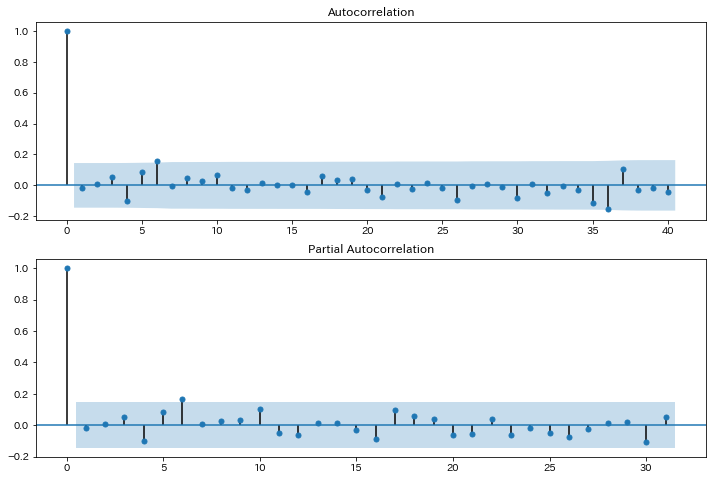

In [12]:
residSARIMA = bestSARIMA.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residSARIMA.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residSARIMA, lags=31, ax=ax2)

In [13]:
pred = bestSARIMA.predict('2020-10-01', '2020-12-06')
pred

2020-10-01     685.645868
2020-10-02     657.370437
2020-10-03     573.000400
2020-10-04     438.624549
2020-10-05     248.796519
                 ...     
2020-12-02    1592.088455
2020-12-03    1817.887406
2020-12-04    1864.051792
2020-12-05    1967.630766
2020-12-06    1700.489094
Freq: D, Length: 67, dtype: float64

- 実際のデータと、予測データを重ね合わせることによって、あてはまり度を観察する。

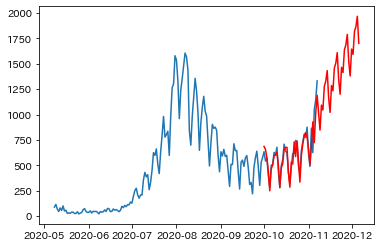

In [14]:
plt.plot(dt)
plt.plot(pred, "r")

------------------


- 予測期間は11/9から12/6まで。
- 2020-11-07 の累計感染者が107557人なのでそこに予測値を足し合わせていく。

In [15]:
ans = pd.DataFrame(pred['2020-11-08':'2020-12-06'])
ans = ans.rename(columns={0: 'predicted_mean'})
ans.insert(0, 'Date', ans.index)
ans['cumsum'] = pd.DataFrame.cumsum(ans['predicted_mean'])
ans['final'] = 107557 + ans['cumsum']
ans.index = np.arange(0, len(ans))
ans

,Date,predicted_mean,cumsum,final
0,2020-11-08,1016.896028,1016.896028,108573.896028
1,2020-11-09,846.068113,1862.964141,109419.964141
2,2020-11-10,1092.057136,2955.021278,110512.021278
3,2020-11-11,1044.444845,3999.466123,111556.466123
4,2020-11-12,1277.636324,5277.102447,112834.102447
5,2020-11-13,1328.832903,6605.935350,114162.935350
6,2020-11-14,1432.685815,8038.621164,115595.621164
7,2020-11-15,1164.032407,9202.653571,116759.653571
8,2020-11-16,1020.518145,10223.171716,117780.171716
9,2020-11-17,1284.994045,11508.165761,119065.165761


In [16]:
ans = ans.drop(index=0)
ans = ans['final']
ans.to_csv('sarima_submit.csv', header=False, index=True)
ans

1     109419.964141
2     110512.021278
3     111556.466123
4     112834.102447
5     114162.935350
6     115595.621164
7     116759.653571
8     117780.171716
9     119065.165761
10    120298.579973
11    121758.108261
12    123263.932071
13    124873.310252
14    126215.477524
15    127415.398515
16    128880.120632
17    130293.028745
18    131931.746519
19    133616.631502
20    135405.093377
21    136926.410971
22    138305.521941
23    139949.437354
24    141541.525809
25    143359.413215
26    145223.465007
27    147191.095773
28    148891.584867
Name: final, dtype: float64